In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import os

In [ ]:
path = os.getcwd()
print ("%s" % path)

In [ ]:
data = pd.read_csv('DS_finalcombined_files.csv')

In [ ]:
data.columns

In [5]:
data=data.drop(['Unnamed: 0'],axis=1)

In [6]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True)

In [7]:
### Remove null columns
for col in data.columns:
    data = data[~data[col].isnull()]

In [8]:
for col in data.columns:
    print(col,pd.isnull(data[col]).sum()/len(data))

Year 0.0
Quarter 0.0
Month 0.0
DayofMonth 0.0
DayOfWeek 0.0
FlightDate 0.0
Reporting_Airline 0.0
Origin 0.0
OriginState 0.0
Dest 0.0
DestState 0.0
CRSDepTime 0.0
Cancelled 0.0
Diverted 0.0
Distance 0.0
DistanceGroup 0.0
ArrDelay 0.0
ArrDelayMinutes 0.0
is_delay 0.0
AirTime 0.0


In [9]:
data['DepHourofDay']=[t[:-2] for t in data['CRSDepTime'].astype(str)]

In [29]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [30]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [31]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data,data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

In [32]:
data.shape

(4816714, 365)

In [33]:
data.rename(columns ={'is_delay':'target'}, inplace=True )

In [34]:
def stratified_samples_df(df,col,n_samples):
    n=min(n_samples,df[col].value_counts().min())
    df_=df.groupby(col).apply(lambda x:x.sample(n))
    df_.index=df_.index.droplevel(0)
    return df_

data_sample=stratified_samples_df(data,'target',100000)

In [35]:
data_sample['target'].value_counts()

1.0    100000
0.0    100000
Name: target, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split

Y=data_sample['target']
x=data_sample.drop(['target'],axis=1)
x.shape

(200000, 364)

In [37]:
X_train, X_test, y_train, y_test=train_test_split(x,Y,test_size=0.2,random_state=42)

In [38]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [39]:
model=RFC(n_estimators=500,max_features=0.25,criterion='entropy',max_depth=11)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
y_predicted=model.predict(X_test)

In [41]:
y_predicted_train=model.predict(X_train)

In [42]:
probabilities=model.predict_proba(X_test)

In [17]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as sklm
def plot_confusion_matrix(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(np.array(y_test), scores)
    
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
    

In [19]:
!pip install scikit-plot

In [20]:
from sklearn import metrics
import scikitplot as skplt


def plot_roc(labels, probs):
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [47]:
plot_confusion_matrix(y_test,y_predicted)


                 Confusion matrix
                 Score positive    Score negative
Actual positive     10237              9756
Actual negative      6109             13898

Accuracy  0.60
 
           Positive      Negative
Num case    19993         20007
Precision    0.63          0.59
Recall       0.51          0.69
F1           0.56          0.64


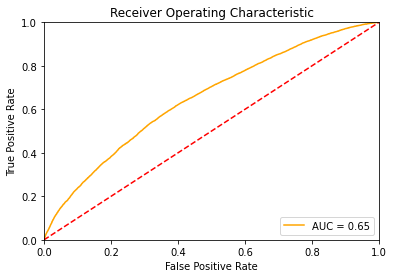

In [48]:
plot_roc(y_test,probabilities)

In [49]:
from sklearn.metrics import classification_report
print("TEST DATASET CLASSIFICATION REPORT")
print(classification_report(y_test,y_predicted))
print("TRAIN DATASET CLASSIFICATION REPORT")
print(classification_report(y_train,y_predicted_train))

TEST DATASET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.63      0.51      0.56     19993
         1.0       0.59      0.69      0.64     20007

    accuracy                           0.60     40000
   macro avg       0.61      0.60      0.60     40000
weighted avg       0.61      0.60      0.60     40000

TRAIN DATASET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.64      0.52      0.57     80007
         1.0       0.60      0.71      0.65     79993

    accuracy                           0.61    160000
   macro avg       0.62      0.61      0.61    160000
weighted avg       0.62      0.61      0.61    160000



# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [11]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday']=False
data_orig['is_holiday']=data_orig['FlightDate'].isin(holidays)

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [12]:
# download data from the link above and place it into the data folder
climate_path=path

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [13]:
weather = pd.read_csv(path+'daily-summaries-2021-11-13T12-55-49.csv') # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = {'USW00023174':'LAX','USW00012960':'IAH','USW00003017':'DEN','USW00094846':'ORD','USW00013874':'ATL','USW00023234':'SFO','USW00003927':'DFW','USW00023183':'PHX','USW00013881':'CLT'}
weather['airport'] = [station_map[weather['STATION'][i]] for i in range(len(weather))]

Create another column called `MONTH` from the `DATE` column.

In [14]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

STATION        DATE  AWND  PRCP  SNOW  ...   TAVG   TMAX   TMIN  airport MONTH
0  USW00023174  2014-01-01    16     0   NaN  ...  131.0  178.0   78.0      LAX    01
1  USW00023174  2014-01-02    22     0   NaN  ...  159.0  256.0  100.0      LAX    01
2  USW00023174  2014-01-03    17     0   NaN  ...  140.0  178.0   83.0      LAX    01
3  USW00023174  2014-01-04    18     0   NaN  ...  136.0  183.0  100.0      LAX    01
4  USW00023174  2014-01-05    18     0   NaN  ...  151.0  244.0   83.0      LAX    01

[5 rows x 11 columns]

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [15]:
weather.SNOW.fillna(int(np.mean(weather.SNOW)), inplace=True)# Enter your code here
weather.SNWD.fillna(int(np.mean(weather.SNWD)), inplace=True)# Enter your code here
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [16]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = np.array([i for i in idx if np.isnan(weather['TAVG'][i])])
TMAX_idx = np.array([i for i in idx if np.isnan(weather['TMAX'][i])])
TMIN_idx = np.array([i for i in idx if np.isnan(weather['TMIN'][i])]) 
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [17]:
weather_impute = weather.groupby([weather.airport,weather.MONTH]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

airport MONTH       TAVG        TMAX       TMIN
0     ATL    01  59.070968  114.600000   8.161290
1     ATL    02  97.212766  152.858156  46.283688

Merge the mean data with the weather data.

In [18]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','airport'], right_on = ['MONTH','airport'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [19]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [20]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [21]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [53]:
print(len(data_orig['Dest'].unique()))  # We dont have Weather report for 271 Destination Airports
print(data_orig.shape)
data_orig=data_orig.drop(['AWND_D','PRCP_D','TAVG_D','SNOW_D'],axis=1)  # Removing all the Destination Weather Report which are provided (Maybe by Mistake)
print(data_orig.shape)

9
(4816714, 30)
(4816714, 26)


In [54]:
sum(data_orig.isna().any())

0

In [57]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O'],
      dtype='object')

In [59]:
data_orig.to_csv(path+'data_orig.csv')   # Saving For Memory Purpose

Convert the categorical data into numerical data using one-hot encoding.

In [6]:
data_orig=pd.read_csv(path+'data_orig.csv') # RELOADING FOR MEMORY PURPOSE 

In [7]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O']]   #, 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D' (.....Maybe Provided by Mistake)


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [8]:
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
    data = pd.concat([data, data_dummies], axis = 1)
# categorical_columns.remove('is_delay')
    data.drop(categorical_columns,axis=1, inplace=True)

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [9]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'Year_2015', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       ...
       'Dest_TUS', 'Dest_TVC', 'Dest_TXK', 'Dest_TYR', 'Dest_TYS', 'Dest_VLD',
       'Dest_VPS', 'Dest_XNA', 'Dest_YUM', 'is_holiday_True'],
      dtype='object', length=350)

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [9]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here


note this combined file will be also used in part B

Create the training and testing sets again.

In [10]:
def stratified_samples_df(df,col,n_samples):
    n=min(n_samples,df[col].value_counts().min())
    df_=df.groupby(col).apply(lambda x:x.sample(n))
    df_.index=df_.index.droplevel(0)
    return df_

data_sample=stratified_samples_df(data,'target',100000)

In [11]:
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    for col in data_sample.columns:
        data_sample = data_sample[~data[col].isnull()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [12]:
from sklearn.model_selection import train_test_split

Y=data_sample['target']
x=data_sample.drop(['target'],axis=1)
x.shape

(199517, 349)

In [13]:
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    X_train, X_test, y_train, y_test=train_test_split(x,Y,test_size=0.2,random_state=42)

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [14]:
from sklearn.linear_model import LogisticRegression 

In [13]:
Y.value_counts()

1.0    100000
0.0    100000
Name: target, dtype: int64

In [16]:
# Instantiate another logistic regression model
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    classifier2 = LogisticRegression(C=.1,max_iter=500)
    classifier2.fit(X_train,y_train)

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

In [22]:
y_predicted=classifier2.predict(X_test)
y_predicted_train=classifier2.predict(X_train)
probabilities=classifier2.predict_proba(X_test)

In [23]:
plot_confusion_matrix(y_test,y_predicted)

                 Confusion matrix
                 Score positive    Score negative
Actual positive     12156              7706
Actual negative      7858             12184

Accuracy  0.61
 
           Positive      Negative
Num case    19862         20042
Precision    0.61          0.61
Recall       0.61          0.61
F1           0.61          0.61


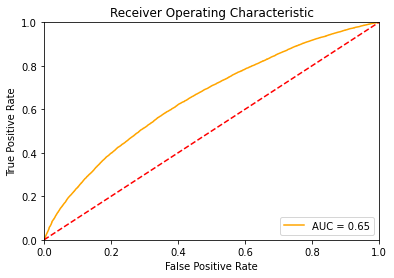

In [24]:
plot_roc(y_test,probabilities)

In [25]:
from sklearn.metrics import classification_report
print("TEST DATASET CLASSIFICATION REPORT")
print(classification_report(y_test,y_predicted))
print("TRAIN DATASET CLASSIFICATION REPORT")
print(classification_report(y_train,y_predicted_train))

TEST DATASET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61     19862
         1.0       0.61      0.61      0.61     20042

    accuracy                           0.61     39904
   macro avg       0.61      0.61      0.61     39904
weighted avg       0.61      0.61      0.61     39904

TRAIN DATASET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.61      0.62      0.62     79832
         1.0       0.62      0.60      0.61     79781

    accuracy                           0.61    159613
   macro avg       0.61      0.61      0.61    159613
weighted avg       0.61      0.61      0.61    159613



Question: did you notice a difference by adding the extra data on the results?

Yes, there are differences with Holidays and Weather report. If we have weather report for Destination Airport, we can expect more good results